In [19]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn.metrics import root_mean_squared_error


In [2]:
df = pd.read_csv("dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


# EDA

In [3]:
df["soil_moisture"].diff().dropna()

ts
2025-04-01 21:30:00   -29.5
2025-04-01 21:45:00   -14.5
2025-04-01 22:00:00    -7.0
2025-04-01 22:15:00    -8.0
2025-04-01 22:30:00     1.0
                       ... 
2025-04-14 10:15:00     2.5
2025-04-14 10:30:00    13.5
2025-04-14 10:45:00    -8.5
2025-04-14 11:00:00    -1.0
2025-04-14 11:15:00    -1.0
Name: soil_moisture, Length: 1129, dtype: float64

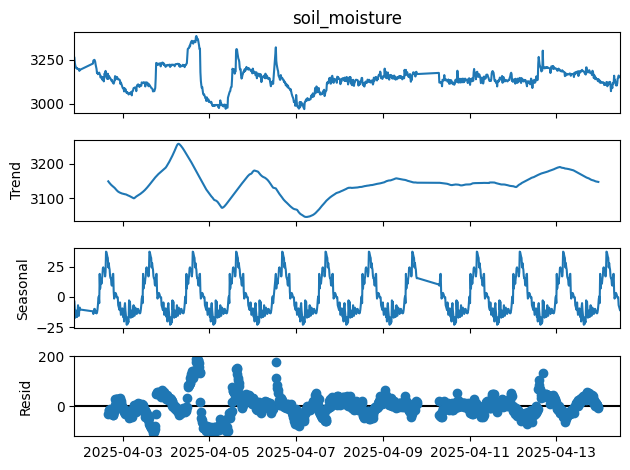

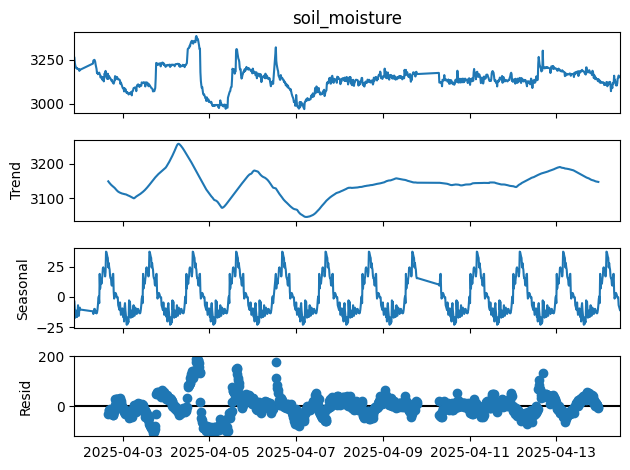

In [4]:
seasonal_decompose(df["soil_moisture"], model="additive", period=96).plot()


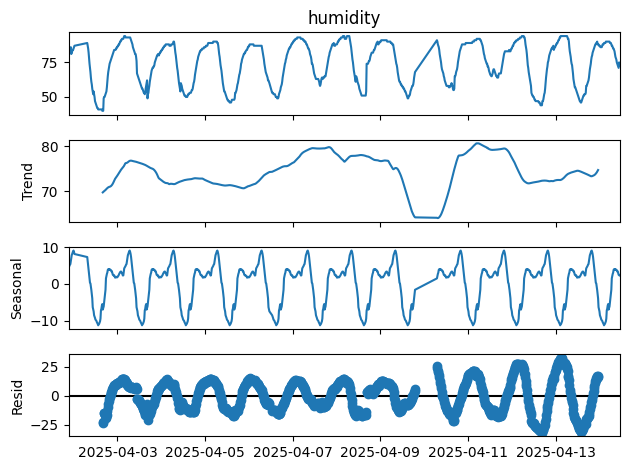

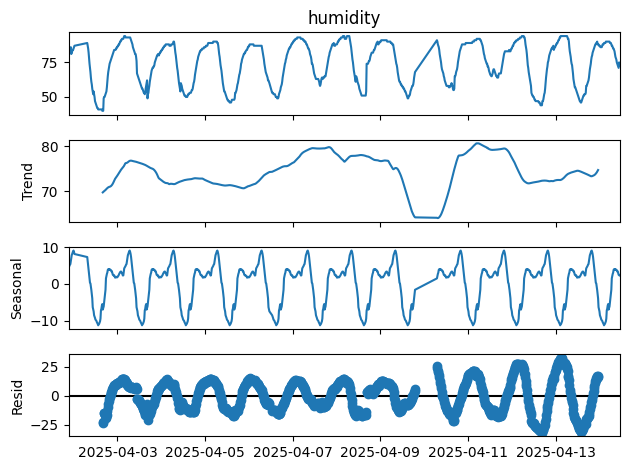

In [5]:
seasonal_decompose(df["humidity"], model="additive", period=96).plot()

## Find D parameter

In [6]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -3.84682253492801
p-value: 0.0024629935755944216
Critial Values:
   1%, -3.4361604996756685
Critial Values:
   5%, -2.864105678204421
Critial Values:
   10%, -2.568136037454102


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

<BarContainer object of 25 artists>

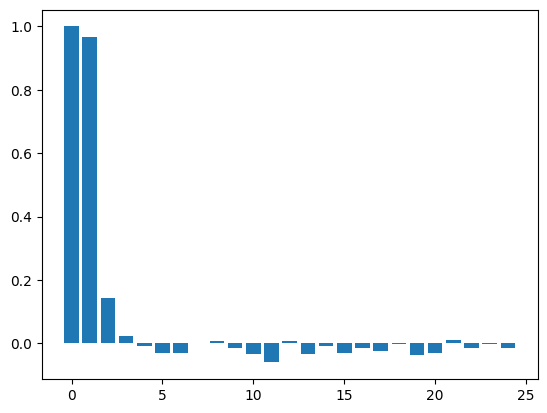

In [7]:
# I believe 2 or 3 is the variable for the term AR in order
pacf_vals = pacf(df["soil_moisture"])
# where did 25 came from?
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Find Q parameter

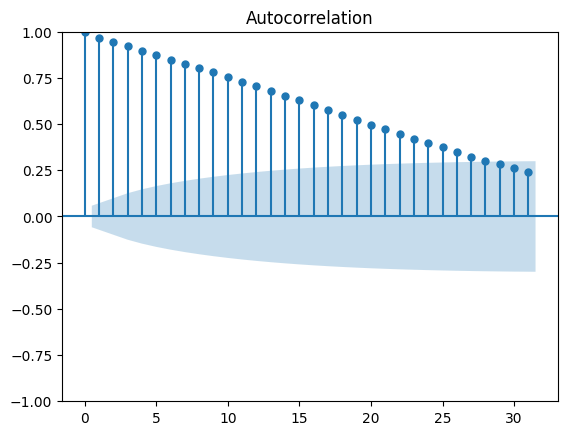

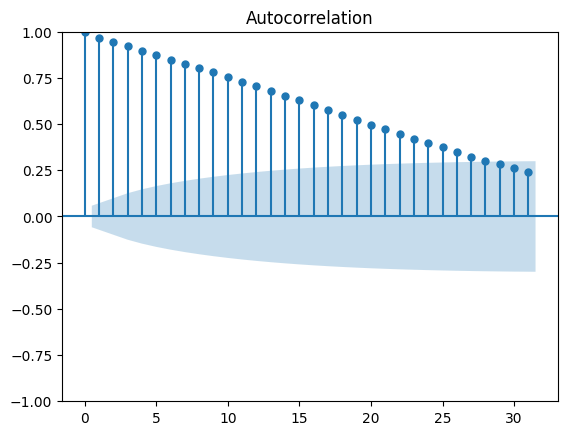

In [8]:
plot_acf(df["soil_moisture"])

## Split the data

In [9]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]

In [10]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [11]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09 00:00:00,651,22.0622,32.1875,3155.0,90,27.8,0.0,59
2025-04-09 00:15:00,652,21.9617,32.2188,3157.5,90,27.7,0.0,59
2025-04-09 00:30:00,653,22.0118,32.1875,3155.0,91,27.6,0.0,59
2025-04-09 00:45:00,654,22.0118,32.1094,3153.0,91,27.5,0.0,59
2025-04-09 01:00:00,655,22.0118,31.9688,3200.0,91,27.5,0.0,67


In [12]:
train_data[["soil_moisture"]]

,soil_moisture
ts,
2025-04-01 21:15:00,3262.0
2025-04-01 21:30:00,3232.5
2025-04-01 21:45:00,3218.0
2025-04-01 22:00:00,3211.0
2025-04-01 22:15:00,3203.0
...,...
2025-04-08 23:00:00,3145.0
2025-04-08 23:15:00,3150.5
2025-04-08 23:30:00,3147.0


In [13]:
arima_model = auto_arima(train_data[["soil_moisture"]], start_p=1, start_q=1,
                      test='padf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5583.246, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5583.161, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5581.728, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5581.980, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5581.218, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.235 seconds


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


wtf?

In [14]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  651
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2789.609
Date:                Fri, 18 Apr 2025   AIC                           5581.218
Time:                        15:33:59   BIC                           5585.695
Sample:                             0   HQIC                          5582.954
                                - 651                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       312.7936      3.829     81.684      0.000     305.288     320.299
===================================================================================
Ljung-Box (L1) (Q):                   3.41   Jarque-Bera (JB):             42304.38
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             2.65
Prob(H) (two-sided):                  0.01   Kurtosis:                        42.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
test_data['soil_moisture'].count()



146

In [16]:
prediction = pd.DataFrame(arima_model.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
prediction.columns = ['predicted']
prediction

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,predicted
651,3155.0
652,3155.0
653,3155.0
654,3155.0
655,3155.0
...,...
792,3155.0
793,3155.0
794,3155.0
795,3155.0


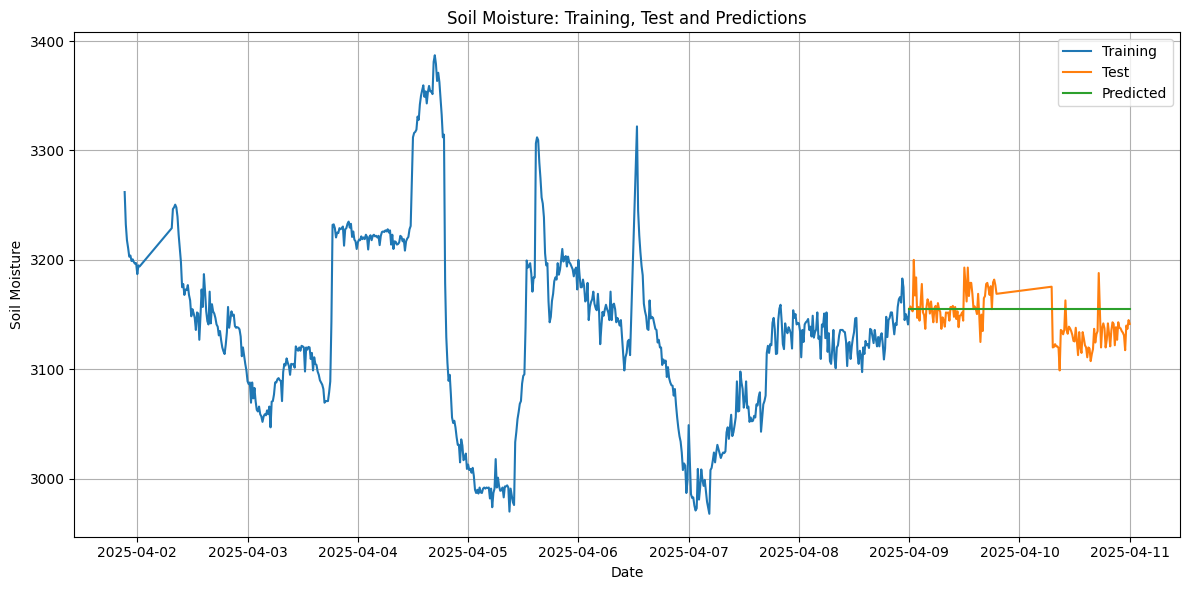

In [17]:
plt.figure(figsize=(12, 6))

# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Get the RMSE
rmse = root_mean_squared_error(test_data['soil_moisture'], prediction)
print(rmse)

21.767450879885295
